## ${\textbf{Libraries}}$

In [1]:
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## ${\textbf{Import Data}}$

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_segmentation = pd.read_csv('/content/drive/My Drive/Customer Analytics/segmentation data.csv', index_col = 0)

## ${\textbf{Explore Data}}$

In [4]:
df_segmentation.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2
100000003,0,0,49,1,89210,0,0
100000004,0,0,45,1,171565,1,1
100000005,0,0,53,1,149031,1,1


In [5]:
df_segmentation.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


## ${\textbf{Correlation Estimate}}$

In [6]:
df_segmentation.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


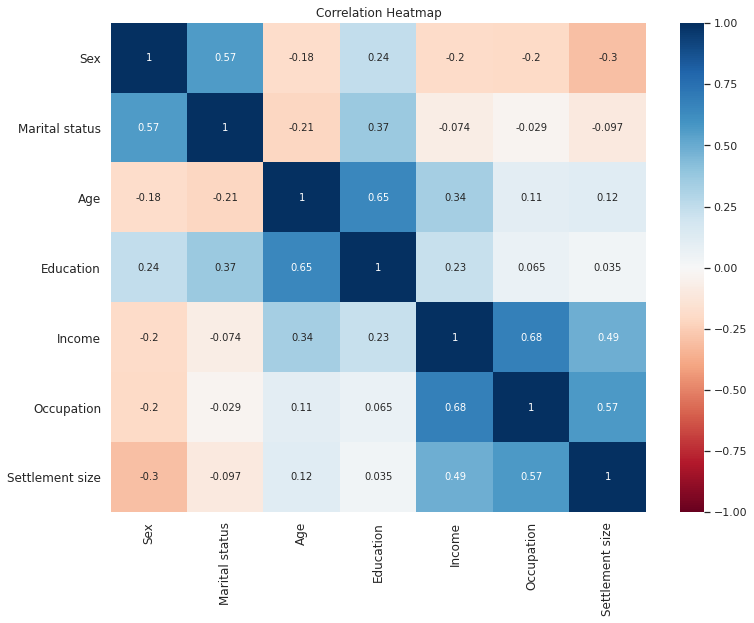

In [7]:
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_segmentation.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

## ${\textbf{Visualize Raw Data}}$

Text(0.5, 1.0, 'Visualization of raw data')

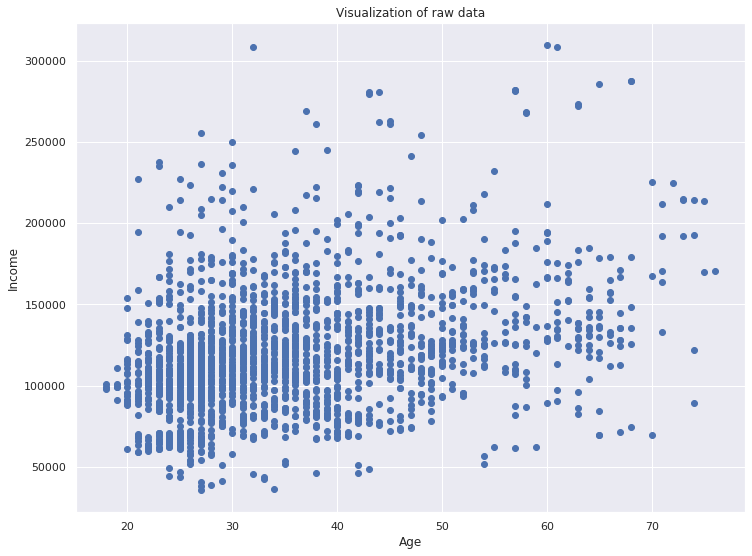

In [8]:
plt.figure(figsize = (12, 9))
plt.scatter(df_segmentation.iloc[:, 2], df_segmentation.iloc[:, 4])
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Visualization of raw data')

## ${\textbf{Standardization}}$

In [9]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

## ${\textbf{Hierarchical Clustering}}$

In [10]:
#Perform Hierachial Clustering
hier_clust = linkage(segmentation_std, method = 'ward')

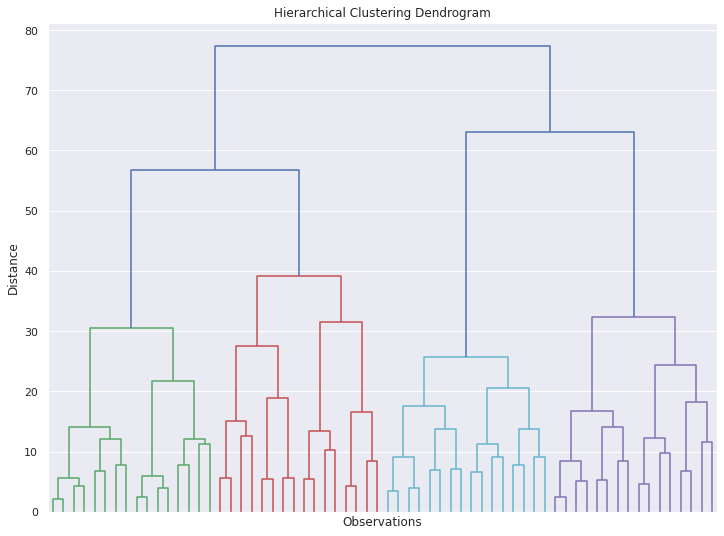

In [11]:
#Visualize Hierachial clusters. P = 5 shows that only exhibited last 5 merged clusters here.
plt.figure(figsize = (12,9))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Distance')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts = False,
           no_labels = True)
plt.show()

## ${\textbf{K-means Clustering}}$

In [12]:
#Perform K-means clustering. We tried 1-10 clusters in the loop. Calculate within clustering sum of squares for each cluster.
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(segmentation_std)
    wcss.append(kmeans.inertia_)

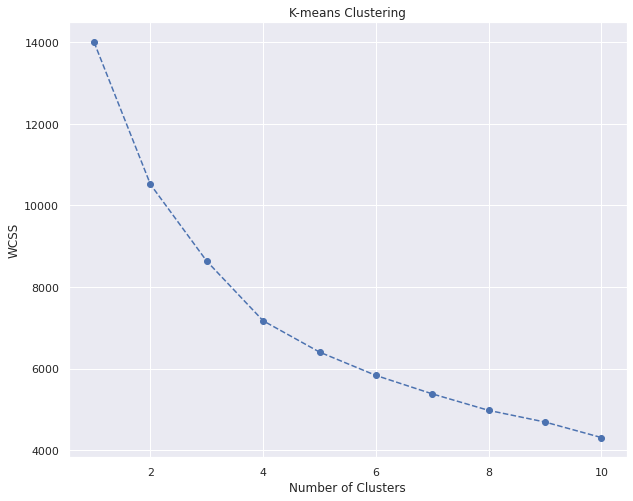

In [13]:
#Visualize K-means clustering and sum of squares results
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [14]:
#Using Elbow Method choose cluster = 4 here.
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [15]:
#Fit the data into 4 clusters
kmeans.fit(segmentation_std)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

### ${\textbf{Results}}$

In [16]:
#Create new data frame with the assigned cluster as the new column 'Segment K-means'
df_segm_kmeans = df_segmentation.copy()
df_segm_kmeans['Segment K-means'] = kmeans.labels_

In [17]:
#Check mean values for each cluster
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695


In [18]:
#Calculate size and proportion of each cluster
df_segm_analysis['N Obs'] = df_segm_kmeans[['Segment K-means','Sex']].groupby(['Segment K-means']).count()
df_segm_analysis['Prop Obs'] = df_segm_analysis['N Obs'] / df_segm_analysis['N Obs'].sum()

In [19]:
df_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
0,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
1,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
2,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
3,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


In [20]:
#Check the characteristic for each cluter, and rename each group.
df_segm_analysis.rename({0:'well-off',
                         1:'fewer-opportunities',
                         2:'career focused',
                         3:'standard'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,N Obs,Prop Obs
Segment K-means,,,,,,,,,
well-off,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266,263,0.1315
fewer-opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290,462,0.2310
career focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807,570,0.2850
standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695,705,0.3525


In [21]:
#Add labels to the table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map({0:'well-off', 
                                                                  1:'fewer opportunities',
                                                                  2:'career focused', 
                                                                  3:'standard'})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


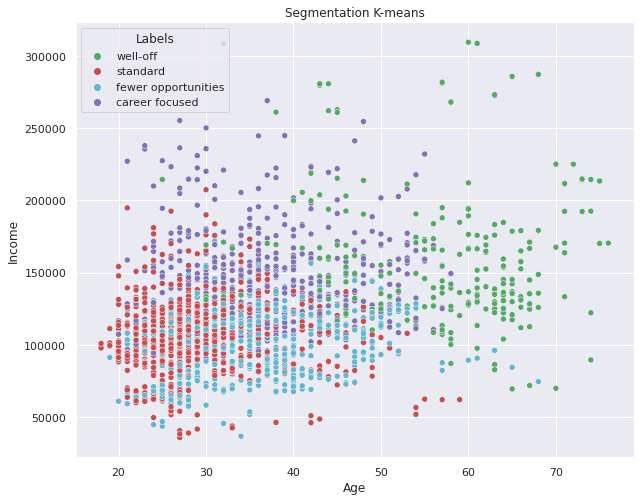

In [22]:
#Visualize the K-means result, each point with color that assigned to the cluster.
x_axis = df_segm_kmeans['Age']
y_axis = df_segm_kmeans['Income']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_kmeans['Labels'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

### ${\textbf{PCA}}$

In [23]:
#Conduct PCA analysis
pca = PCA()

In [24]:
#Fit PCA with standardized data
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [25]:
#Check variance explained by each component
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

Text(0, 0.5, 'Cumulative Explained Variance')

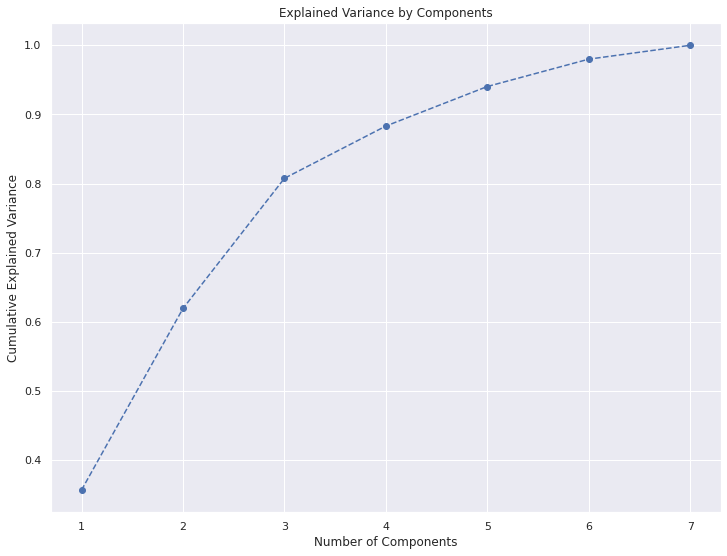

In [26]:
#Visualize the cumulative variance expalined by components
plt.figure(figsize = (12,9))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [27]:
#We choose explained variance>=80%, so components = 3 is appropriate here
pca = PCA(n_components = 3)

In [28]:
#Fit the model with components we chose
pca.fit(segmentation_std)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### ${\textbf{PCA Results}}$

In [29]:
#To check the correlation between components and orginial features
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

In [30]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df_segmentation.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


([<matplotlib.axis.YTick at 0x7f8851a81350>,
 [Text(0, 0.5, 'Component 1'),
  Text(0, 1.5, 'Component 2'),
  Text(0, 2.5, 'Component 3')])

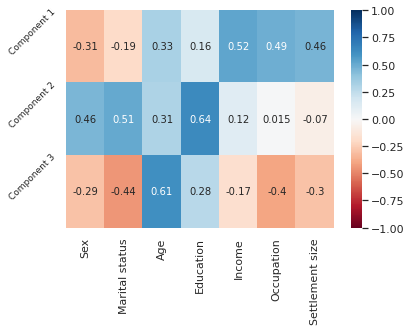

In [31]:
#Visualize the correlation 
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 45,
           fontsize = 9)

In [32]:
pca.transform(segmentation_std)

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

In [33]:
scores_pca = pca.transform(segmentation_std)

### ${\textbf{K-means clustering with PCA}}$

In [34]:
#Perform K-means with the transformed data
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

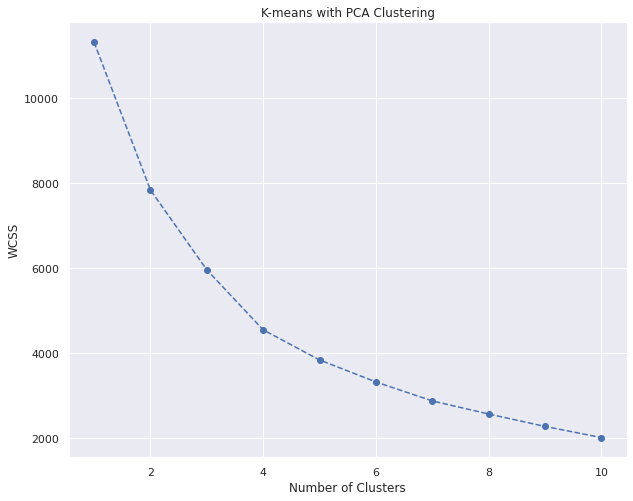

In [35]:
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [36]:
#We choose 4 as clusters by elbow method here
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [37]:
#Fit transformed data with K-means
kmeans_pca.fit(scores_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

### ${\textbf{K-means clustering with PCA Results}}$

In [38]:
#Create the new data frame with originial features and PCA scores and clusters
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [39]:
df_segm_pca_kmeans

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,0
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,2
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,1
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,3
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,3
...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,1
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,2
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,1
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,2


In [40]:
#Check means by K-means group
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953
1,0.305011,0.095861,35.315904,0.760349,93633.372549,0.250545,0.039216,-1.047610,-0.904856,1.005493
2,0.900576,0.963977,28.920749,1.061960,107571.126801,0.677233,0.439481,-1.106034,0.705300,-0.776925
3,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046


In [41]:
#Calculate size and proportion of each cluster
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'well-off', 
                                                          1:'fewer opportunities',
                                                          2:'standard', 
                                                          3:'career focused'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,
well-off,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953,264,0.1320
fewer opportunities,0.305011,0.095861,35.315904,0.760349,93633.372549,0.250545,0.039216,-1.047610,-0.904856,1.005493,459,0.2295
standard,0.900576,0.963977,28.920749,1.061960,107571.126801,0.677233,0.439481,-1.106034,0.705300,-0.776925,694,0.3470
career focused,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046,583,0.2915


In [42]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'well-off', 
                                                          1:'fewer opportunities',
                                                          2:'standard', 
                                                          3:'career focused'})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


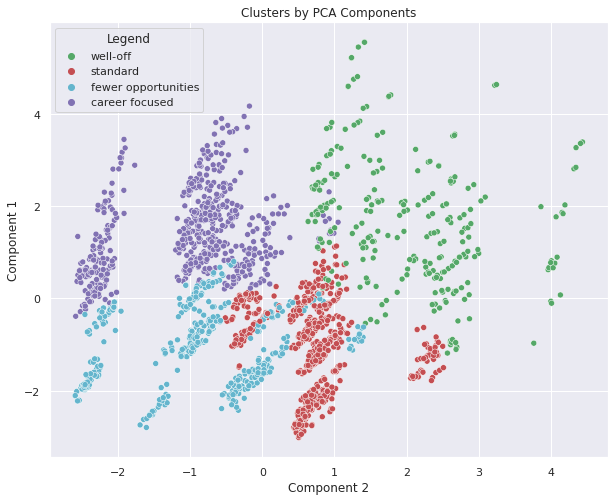

In [43]:
#Visualize PCA component, with x represents component 2 and y represents component 1
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()